In [1]:
import pandas as pd
import numpy as np
# 匯入 display 和 HTML
from IPython.display import display, HTML

# --- 1. 常數與假設 ---
t0 = 32.06  
rho0 = 0.9970  # 假設純水密度

print(f"--- 使用的溶劑常數 (Solvent Constants) ---")
print(f"純水平均時間 (t0): {t0} s")
print(f"假設純水密度 (rho0): {rho0} g/cm³\n")

# --- 2. 原始數據 ---
data_A = {
    'C_raw': [0.5, 0.25, 0.125, 0.0675],
    't_raw': [36.86, 34.68, 33.40, 33.16],
    'rho_raw': [1.00678, 0.99732, 0.99248, 0.99224]
}

data_B = {
    'C_raw': [0.5, 0.25, 0.125, 0.0625],
    't_raw': [40.07, 36.51, 35.17, 34.30],
    'rho_raw': [1.01665, 1.01804, 1.01196, 1.01436]
}

# --- 3. 建立計算函數 ---
def calculate_and_format_report(data, t0, rho0):
    """
    計算數據並回傳一個欄位名稱已格式化為 Unicode 的 DataFrame。
    """
    # 1. 使用簡單的內部名稱進行計算
    df = pd.DataFrame(data)
    
    eta_r = (df['t_raw'] / t0) * (df['rho_raw'] / rho0)
    eta_sp = eta_r - 1
    ln_eta_r = np.log(eta_r)
    eta_sp_C = eta_sp / df['C_raw']
    ln_eta_r_C = ln_eta_r / df['C_raw']

    # 2. 建立一個新的 DataFrame，
    #    其 "鍵" (欄位名) 就是我們要顯示的 Unicode 字串
    #    (ρ, η, ³, ᵣ, ₛ, ₚ 都是單一 Unicode 字符)
    report_df = pd.DataFrame({
        'C (g/100ml)': df['C_raw'],
        't (s)': df['t_raw'],
        'ρ (g/cm³)': df['rho_raw'], # ρ (rho) 和 ³ (superscript 3)
        'ηᵣ': eta_r,                 # η (eta) 和 ᵣ (subscript r)
        'ηₛₚ': eta_sp,               # η (eta), ₛ (subscript s), ₚ (subscript p)
        'ln(ηᵣ)': ln_eta_r,
        'ηₛₚ / C': eta_sp_C,
        'ln(ηᵣ) / C': ln_eta_r_C
    })
    
    return report_df

# --- 4. 計算 ---
df_A_report = calculate_and_format_report(data_A, t0, rho0)
df_B_report = calculate_and_format_report(data_B, t0, rho0)

# --- 5. 顯示為美化的 HTML (適合截圖) ---

# 顯示 PVOH (A)
display(HTML('<h2>PVOH (A) 結報數據</h2>'))
display(HTML(df_A_report.to_html(
    index=False,         # 隱藏 index
    float_format='%.6f'  # 統一小數點
    # 這次我們不需要 escape=False，因為我們用的是標準文字
)))

# 顯示 PVOH (B)
display(HTML('<h2>PVOH (B) 結報數據</h2>'))
display(HTML(df_B_report.to_html(
    index=False,
    float_format='%.6f'
)))

--- 使用的溶劑常數 (Solvent Constants) ---
純水平均時間 (t0): 32.06 s
假設純水密度 (rho0): 0.997 g/cm³



C (g/100ml),t (s),ρ (g/cm³),ηᵣ,ηₛₚ,ln(ηᵣ),ηₛₚ / C,ln(ηᵣ) / C
0.500000,36.860000,1.006780,1.160997,0.160997,0.149279,0.321995,0.298559
0.250000,34.680000,0.997320,1.082069,0.082069,0.078875,0.328276,0.315500
0.125000,33.400000,0.992480,1.037074,0.037074,0.036403,0.296588,0.291223
0.067500,33.160000,0.992240,1.029373,0.029373,0.028949,0.435149,0.428880


C (g/100ml),t (s),ρ (g/cm³),ηᵣ,ηₛₚ,ln(ηᵣ),ηₛₚ / C,ln(ηᵣ) / C
0.500000,40.070000,1.016650,1.274477,0.274477,0.242536,0.548955,0.485072
0.250000,36.510000,1.018040,1.162835,0.162835,0.150861,0.651339,0.603443
0.125000,35.170000,1.011960,1.113466,0.113466,0.107478,0.907730,0.859823
0.062500,34.300000,1.014360,1.088498,0.088498,0.084799,1.415965,1.356777


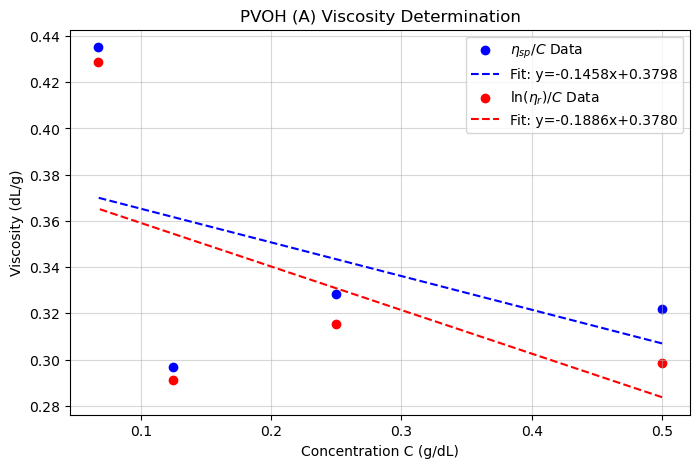

--- PVOH (A) Analysis Results ---
Intercept (Huggins, ηsp/C): 0.3798 dL/g
Intercept (Kraemer, lnηr/C): 0.3780 dL/g
Intrinsic Viscosity [η]: 0.3789 dL/g
Molecular Weight M: 20535.58 g/mol



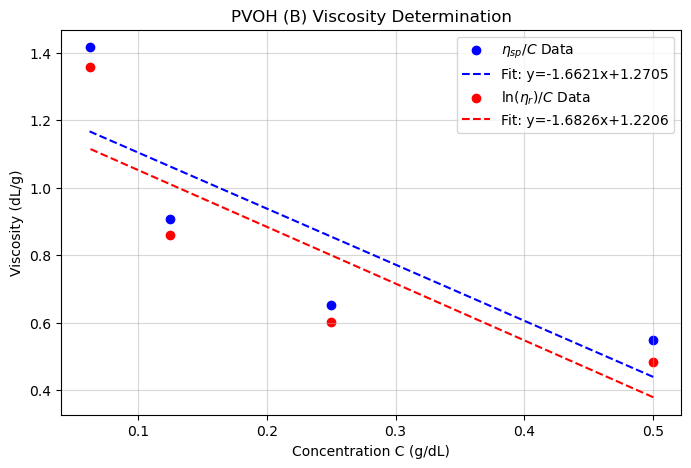

--- PVOH (B) Analysis Results ---
Intercept (Huggins, ηsp/C): 1.2705 dL/g
Intercept (Kraemer, lnηr/C): 1.2206 dL/g
Intrinsic Viscosity [η]: 1.2456 dL/g
Molecular Weight M: 98301.44 g/mol



In [2]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- 參數設定 (來自講義) ---
K = 2.0e-4
a = 0.76

# --- 定義作圖與分析函數 ---
def analyze_viscosity(df_report, name):
    # 準備 X, Y 數據
    # 注意: 我們需要將欄位名稱對應回你在 df_report 中使用的名稱
    # C 欄位: 'C (g/100ml)'
    # ηsp/C 欄位: 'ηₛₚ / C'
    # ln(ηr)/C 欄位: 'ln(ηᵣ) / C'
    
    x = df_report['C (g/100ml)']
    y_sp = df_report['ηₛₚ / C']
    y_ln = df_report['ln(ηᵣ) / C']
    
    # 1. 線性回歸 (Linear Regression)
    # y = slope * x + intercept
    slope_sp, intercept_sp, r_sp, p_sp, err_sp = linregress(x, y_sp)
    slope_ln, intercept_ln, r_ln, p_ln, err_ln = linregress(x, y_ln)
    
    # 2. 計算極限黏度 [η] (取兩條線截距的平均值)
    intrinsic_viscosity = (intercept_sp + intercept_ln) / 2
    
    # 3. 計算分子量 M
    # 公式: [η] = K * M^a  =>  M = ([η] / K)^(1/a)
    M = (intrinsic_viscosity / K) ** (1/a)
    
    # 4. 作圖
    plt.figure(figsize=(8, 5))
    
    # 繪製 ηsp/C 的數據點與回歸線
    plt.scatter(x, y_sp, color='blue', label=r'$\eta_{sp}/C$ Data')
    plt.plot(x, slope_sp * x + intercept_sp, color='blue', linestyle='--', 
             label=f'Fit: y={slope_sp:.4f}x+{intercept_sp:.4f}')
    
    # 繪製 ln(ηr)/C 的數據點與回歸線
    plt.scatter(x, y_ln, color='red', label=r'$\ln(\eta_r)/C$ Data')
    plt.plot(x, slope_ln * x + intercept_ln, color='red', linestyle='--', 
             label=f'Fit: y={slope_ln:.4f}x+{intercept_ln:.4f}')
    
    plt.title(f'{name} Viscosity Determination')
    plt.xlabel('Concentration C (g/dL)')
    plt.ylabel('Viscosity (dL/g)')
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    # 顯示圖表
    plt.show()
    
    # 5. 顯示計算結果
    print(f"--- {name} Analysis Results ---")
    print(f"Intercept (Huggins, ηsp/C): {intercept_sp:.4f} dL/g")
    print(f"Intercept (Kraemer, lnηr/C): {intercept_ln:.4f} dL/g")
    print(f"Intrinsic Viscosity [η]: {intrinsic_viscosity:.4f} dL/g")
    print(f"Molecular Weight M: {M:.2f} g/mol\n")

# --- 執行分析 ---
# 假設你前面的 DataFrame 變數名稱是 df_A_report 和 df_B_report
analyze_viscosity(df_A_report, "PVOH (A)")
analyze_viscosity(df_B_report, "PVOH (B)")